In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

2024-11-15 09:41:22.896231: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from datasets import load_dataset

# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')


Using the latest cached version of the dataset since Falah/Alzheimer_MRI couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/nicopoliczer/.cache/huggingface/datasets/Falah___alzheimer_mri/default/0.0.0/daac24f9597236b45837d82f7eb9c9ad1f8c60c8 (last modified on Fri Nov 15 08:50:17 2024).


In [3]:
# Split training data into train and validation tensorflow datasets

datasets = dataset.train_test_split(test_size=0.2)
ds_train_ = datasets["train"].to_tf_dataset(columns='image', shuffle=True, label_cols='label')
ds_valid_ = datasets["test"].to_tf_dataset(columns='image', shuffle=False, label_cols='label')

2024-11-15 09:43:15.172156: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-15 09:43:15.172883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
alzheimers_state = {
    0 : "No Degeneration",
    1 : "Mild Degeneration",
    2 : "Moderate Degeneration",
    3 : "Severe Degeneration"
}

In [5]:
# Data Pipeline
# Converts image to float, and add one grayscale channel
def preprocess(image, label):
    image = tf.expand_dims(image, axis=-1)  # Shape becomes (128, 128, 1)
    image = tf.image.grayscale_to_rgb(image) # Shape become (128, 128, 3)
    
    image = tf.cast(image, tf.float32)
    # Normalize pixel values to [0, 1]
    image /= 255.0
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

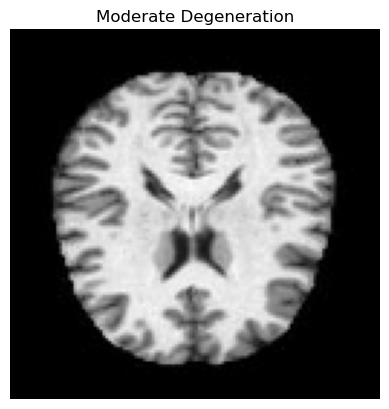

2024-11-15 09:43:16.334893: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


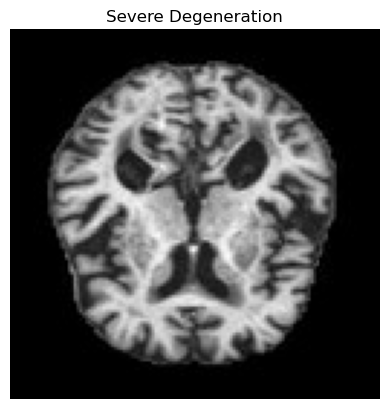

In [6]:
# Take a look at some of our sample MRI data
for image, label in ds_train.take(2): 
    # Convert image to numpy array and display with matplotlib 
    plt.imshow(image.numpy()) # Convert TensorFlow tensor to a NumPy array
    plt.title(alzheimers_state[label.numpy()]) # Print label
    plt.axis('off')
    plt.show()

In [15]:
# Batch our datasets
ds_train_batched = ds_train.batch(batch_size=64)
ds_valid_batched = ds_valid.batch(batch_size=64)

In [8]:
# import VGG16 pretrained base
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable =False

In [31]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax'),
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                524352    
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 4)                 260       
                                                                 
Total params: 15,239,300
Trainable params: 524,612
Non-trainable params: 14,714,688
_________________________________________________________________


In [32]:
model.compile(
    optimizer='adam',
     # Labels are integers 0-3, use sparse categorical crossentropy for loss function
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
from tensorflow.keras import callbacks
earlystopping = callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    restore_best_weights=True)

history = model.fit(
    ds_train_batched,
    validation_data=ds_valid_batched,
    epochs=60,
    verbose=True,
    callbacks=[earlystopping]
)

Epoch 1/60


2024-11-15 12:26:58.335987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-15 12:26:58.437157: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_2.


64/64 [==============================] - ETA: 0s - loss: 4.2424 - accuracy: 0.4099

2024-11-15 12:27:34.897879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


64/64 [==============================] - 47s 716ms/step - loss: 4.2424 - accuracy: 0.4099 - val_loss: 1.5711 - val_accuracy: 0.5381
Epoch 2/60
64/64 [==============================] - 46s 716ms/step - loss: 3.5221 - accuracy: 0.4409 - val_loss: 1.4964 - val_accuracy: 0.5322
Epoch 3/60
64/64 [==============================] - 47s 727ms/step - loss: 2.6017 - accuracy: 0.4761 - val_loss: 1.3631 - val_accuracy: 0.5303
Epoch 4/60
64/64 [==============================] - 46s 714ms/step - loss: 1.9723 - accuracy: 0.5110 - val_loss: 1.1649 - val_accuracy: 0.5508
Epoch 5/60
64/64 [==============================] - 45s 709ms/step - loss: 1.5412 - accuracy: 0.5320 - val_loss: 1.0579 - val_accuracy: 0.5605
Epoch 6/60
64/64 [==============================] - 259s 4s/step - loss: 1.2366 - accuracy: 0.5596 - val_loss: 0.9889 - val_accuracy: 0.5742
Epoch 7/60
64/64 [==============================] - 44s 684ms/step - loss: 1.0446 - accuracy: 0.5916 - val_loss: 0.9346 - val_accuracy: 0.5947
Epoch 8/60
6

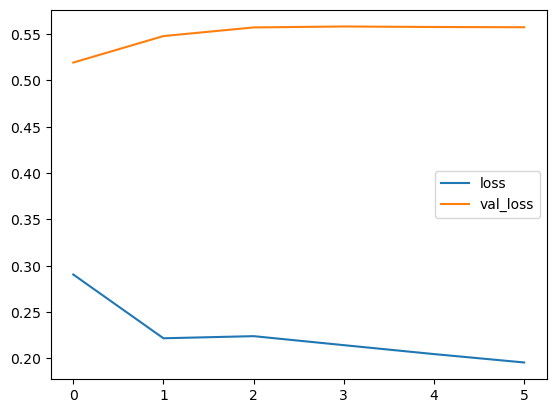

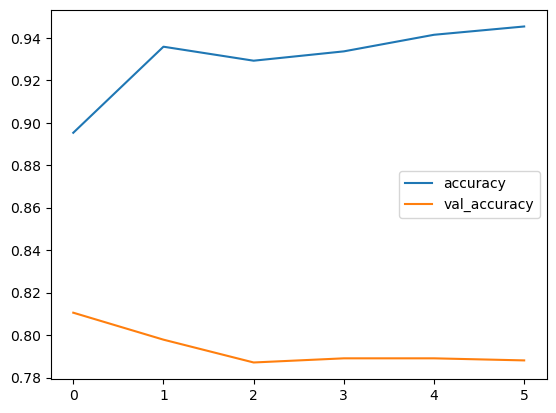

In [26]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();